In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100
import seaborn as sns

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.outliers_influence as sso

In [2]:
def check_coef(df, threshold=0):
    import seaborn as sns
    df_coef = df.corr()
    sns.heatmap(df.corr(), annot=True)

In [3]:
def scatter_plot(df,x_label, y_label):
    y = df[y_label].values
    for xi in x_label:
        x = df[xi].values
        _ = plt.plot(x, y, 'o', color = 'b')
        plt.xlabel(xi)
        plt.ylabel(y_label)
        plt.title(xi+" to "+y_label)
        plt.show()

In [4]:
# x_labels must be a list
def linear_regression(df, x_labels, y_label):
    x_param = ''
    for x in x_labels:
        x_param+="Q(\"{}\")+".format(x)
    x_param = x_param[:-1]
    y_label  = "Q(\""+y_label+"\")"
    df1_result = smf.ols(y_label+"~"+x_param, data = df).fit()
    print(df1_result.summary())
    return df1_result

In [5]:
def check_outlier(df, x_label, y_label, df1_result):
    import statsmodels.stats.outliers_influence as sso

    x = df[x_label].values
    st, data, ss2 = sso.summary_table(df1_result, alpha=0.05)
    y = data[:, 10]

    plt.plot(x, y, 'o', color = 'gray')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.show()
    return st, data, ss2

In [6]:
def check_influential_observ(df1, x_label, y_label, df1_result):
    st, data, ss2 = sso.summary_table(df1_result, alpha=0.05)
    x = df1[x_label].values
    cook_dist = data[:, 11]
    print(cook_dist)
    plt.plot(x, cook_dist, 'o', color = 'gray')
    plt.axhline(y=1, color="red")
    plt.show()

In [7]:
def check_norm(resid, bins='auto'):
    # Run Shapiro test
    stat, p = stats.shapiro(resid)
    print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')
    
    # Draw historgram
    print('Histogram')
    plt.hist(resid, bins=bins)
    plt.show()
    
    # Draw QQ plot
    print('QQ plot')
    fig = sm.qqplot(resid, stats.norm, fit=True, line='45')
    plt.show()

In [8]:
def getEquation(df_result):
    print("y = ",end="")
    text = ''
    for name, coef in zip(df_result.params.index, df_result.params):
        text+="{:.3f} * {} + ".format(coef, name)
    text = text[:-2]
    print(text)

In [9]:
def reg_analysis(df, x_labels, y_label):
    df.fillna(value=0, inplace=True)
    display(df.describe())
    check_coef(df[x_labels])
    print("1 if larger than 0.5...")
    scatter_plot(df,x_labels, y_label)
    df_result = linear_regression(df, x_labels, y_label)
    getEquation(df_result)
    print("Residual Test...")
    print("Normality")
    check_norm(df_result.resid_pearson)
    print("Influential Observations")
    check_influential_observ(df, 'student_id', y_label, df_result)
    print("Outliers")
    st, data, ss2 = check_outlier(df, 'student_id', y_label, df_result)
    return st, data, ss2

In [10]:
def _std_helper(df_col):
    return (df_col - df_col.mean())/df_col.std()

In [11]:
def standardize(df, x_labels):
    for x_label in x_labels:
        df[x_label] = _std_helper(df[x_label])
    return df

In [71]:
#forward_selection(input_df = df18_6, depv = 'Score', indepv = ['Drive', 'Fair', 'Green', 'Putt', 'Sand'])
def forward_selection(input_df, x_labels, y_label):
    selected = []
    candidates = x_labels.copy()

    best_adjr2 = -1
    best_subset = []

    while len(candidates) > 0:
        print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []

        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            
            modelstr =  "Q(\"{}\")".format(y_label)+ " ~ " + "+".join(["Q(\"{}\")".format(x_label) for x_label in tmplist])
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            #print(df18_result6tmp.summary())
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        
        #find the best element
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]

        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")

        print("===============")
        print("Current best model: ", selected)
        print("Current best AdjR2: ", this_adjr2)


        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected


        candidates = set(candidates) - set(selected)
        candidates = list(candidates)

    #print out the best result
    print("best_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)

    #run the best model again
    modelstr = "Q(\"{}\")".format(y_label) + " ~ " + "+".join(["Q(\"{}\")".format(x_label) for x_label in best_subset])
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary())

In [72]:
x_labels = cols
y_label = 'final'
forward_selection(DSAP107_sub, cols, y_label)

Current Candidates:  ['total_watch_time', 'all_actions', 'period 0', 'period 1', 'period 2', 'period 3', 'period 4', 'period 5', 'avg_playback_rate']
Current best model:  ['total_watch_time']
Current best AdjR2:  0.3799304982567857
Current Candidates:  ['period 3', 'period 1', 'period 5', 'period 0', 'period 4', 'avg_playback_rate', 'period 2', 'all_actions']
Current best model:  ['total_watch_time', 'avg_playback_rate']
Current best AdjR2:  0.46596942798832697
Current Candidates:  ['period 3', 'period 5', 'period 1', 'period 0', 'period 4', 'period 2', 'all_actions']
Current best model:  ['total_watch_time', 'avg_playback_rate', 'period 4']
Current best AdjR2:  0.4785752429512693
Current Candidates:  ['period 3', 'period 1', 'period 5', 'period 0', 'period 2', 'all_actions']
Current best model:  ['total_watch_time', 'avg_playback_rate', 'period 4', 'period 0']
Current best AdjR2:  0.47666237803330047
Current Candidates:  ['period 2', 'period 3', 'period 5', 'period 1', 'all_actions']


## OR107

In [12]:
OR107.columns

NameError: name 'OR107' is not defined

In [ ]:
x_labels = list(OR107.columns[3:])
y_label = "final"
st, data, ss2 = reg_analysis(OR107, x_labels, y_label)

In [ ]:
pd.DataFrame(columns=ss2)

## Check the outliers

In [371]:
outliers = pd.DataFrame(data[ (abs(data[:,10]))>2])

In [372]:
outliers

,0,1,2,3,4,5,6,7,8,9,10,11
0,49.0,30.0,89.456950,14.935340,59.697636,119.216264,27.526030,151.387870,-59.456950,22.801774,-2.607558,0.324129
1,59.0,76.0,22.588566,5.623666,11.383167,33.793965,-32.867570,78.044702,53.411434,26.671326,2.002579,0.019810
2,67.0,96.0,30.491686,6.545707,17.449080,43.534292,-25.364662,86.348035,65.508314,26.460139,2.475736,0.041677


## check influential observations

In [373]:
influ_obs = pd.DataFrame(data[(abs(data[:,11]))>1])

In [374]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,53.0,74.961382,24.638539,25.868021,124.054744,1.749497,148.173268,-21.961382,11.658801,-1.883674,1.760724


## Extract outliers and influential data

In [375]:
OR107.loc[list(outliers[0])+list(influ_obs[0])]

,student_id,project,final,total_watch_time,avg_playback_rate,avg_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq
49.0,137,78.78,73.0,10342.333333,1.600413,0.239367,151,16,500,57,119
59.0,147,90.80,71.0,22731.500000,1.741416,0.572459,24491,222,14296,544,1097
67.0,155,96.50,53.0,35500.833333,1.403376,0.720488,3683,125,2516,31,424
21.0,109,0.00,0.0,0.000000,0.000000,0.000000,0,0,0,0,0


In [387]:
OR107_extract = OR107[~OR107.index.isin(outliers[0])]

## DSAP107

In [51]:
DSAP107 = pd.read_excel('../../code/Nick/DSAP107.xlsx')

In [52]:
len(DSAP107)

105

In [53]:
DSAP107['midterm'] = DSAP107['Midterm (2042)']
DSAP107['final'] = DSAP107['Final (2346)']

In [54]:
DSAP107_sub = DSAP107[['student_id','midterm', 'final', 'total_watch_time', 'watch_freq',
       'backward_sec', 'backward_times', 'forward_sec', 'forward_times',
       'pause_freq', 'period 0', 'period 1', 'period 2', 'period 3',
       'period 4', 'period 5', 'avg_playback_rate']]

## calculate period proportion

In [55]:
DSAP107_sub.loc[:,'period 0'] = DSAP107_sub['period 0']/DSAP107_sub['total_watch_time']
DSAP107_sub.loc[:,'period 1'] = DSAP107_sub['period 1']/DSAP107_sub['total_watch_time']
DSAP107_sub.loc[:,'period 2'] = DSAP107_sub['period 2']/DSAP107_sub['total_watch_time']
DSAP107_sub.loc[:,'period 3'] = DSAP107_sub['period 3']/DSAP107_sub['total_watch_time']
DSAP107_sub.loc[:,'period 4'] = DSAP107_sub['period 4']/DSAP107_sub['total_watch_time']
DSAP107_sub.loc[:,'period 5'] = DSAP107_sub['period 5']/DSAP107_sub['total_watch_time']

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [56]:
DSAP107_sub.head()

,student_id,midterm,final,total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
0,64,0,0.0,13331.983333,0.545342,551,26,1517,10,112,0.030753,0.000000,0.259826,0.376452,0.288089,0.044880,1.492651
1,65,0,0.0,3572.000000,0.092675,88,5,442,9,13,0.998600,0.000000,0.000000,0.000000,0.000000,0.001400,1.000000
2,66,82,76.0,36625.000000,1.033947,6685,171,7912,248,237,0.718635,0.034567,0.060833,0.083331,0.022498,0.080137,1.000000
3,67,79,79.0,18789.383333,0.963616,6459,116,6784,161,255,0.058242,0.073652,0.182785,0.615654,0.057213,0.012454,1.847426
4,68,52,57.0,13719.766667,0.673371,3958,83,6892,171,244,0.048835,0.000000,0.047122,0.594231,0.278944,0.030868,1.742595


In [57]:
DSAP107_sub.columns

Index(['student_id', 'midterm', 'final', 'total_watch_time', 'watch_freq',
       'backward_sec', 'backward_times', 'forward_sec', 'forward_times',
       'pause_freq', 'period 0', 'period 1', 'period 2', 'period 3',
       'period 4', 'period 5', 'avg_playback_rate'],
      dtype='object')

## add up all actions (incl. forward backward pause)

In [58]:
DSAP107_sub.loc[:,'thinking_times'] = DSAP107_sub['backward_times']+DSAP107_sub['pause_freq']
DSAP107_sub.loc[:,'boring_times'] = DSAP107_sub['forward_times']+DSAP107_sub['pause_freq']
DSAP107_sub.loc[:,'all_actions'] = DSAP107_sub['forward_times']+DSAP107_sub['backward_times']

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [59]:
cols = ['total_watch_time','all_actions', 'period 0', 'period 1', 'period 2', 'period 3',
       'period 4', 'period 5', 'avg_playback_rate']

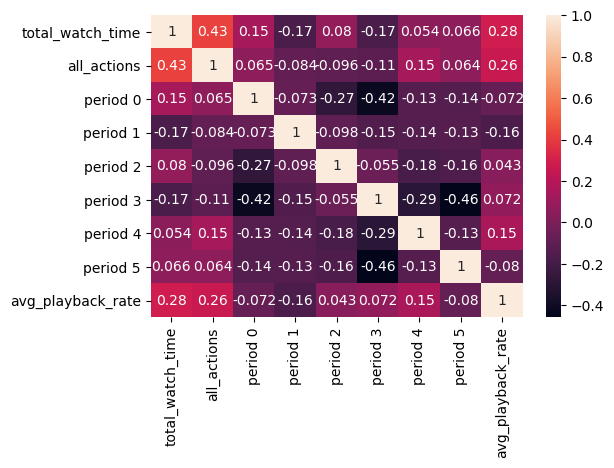

In [60]:
check_coef(DSAP107_sub[cols])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,student_id,midterm,final,total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate,thinking_times,boring_times,all_actions
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.00000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,116.000000,47.838095,47.890476,18651.977256,0.794627,6124.809524,159.295238,5675.00000,227.990476,255.361905,0.149212,0.019328,0.091802,0.300740,0.194864,0.186910,1.436895,414.657143,483.352381,387.285714
std,30.454885,41.221989,34.290121,12435.747678,0.509255,8258.033065,190.863318,7785.35521,395.543625,300.335586,0.181474,0.103123,0.126142,0.234093,0.155768,0.184532,0.459068,445.700310,666.359729,538.309814
min,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,0.000000,0.000000,12851.733333,0.540704,702.000000,26.000000,894.00000,13.000000,77.000000,0.005333,0.000000,0.000000,0.136433,0.060000,0.047477,1.248772,112.000000,118.000000,40.000000
50%,116.000000,73.000000,60.000000,18766.033333,0.793550,3856.000000,68.000000,2601.00000,71.000000,159.000000,0.096391,0.000000,0.040204,0.286305,0.187044,0.152464,1.480752,258.000000,266.000000,192.000000
75%,142.000000,85.000000,76.000000,26227.966667,1.081602,8914.000000,242.000000,6892.00000,292.000000,321.000000,0.196236,0.000000,0.150168,0.399171,0.288089,0.282104,1.745431,569.000000,574.000000,457.000000
max,168.000000,98.000000,91.500000,69769.233333,2.687745,47268.000000,869.000000,46298.00000,2353.000000,2282.000000,0.998600,1.000000,0.760000,1.000000,0.674660,0.991624,2.380491,2539.000000,4421.000000,2896.000000


1 if larger than 0.5...


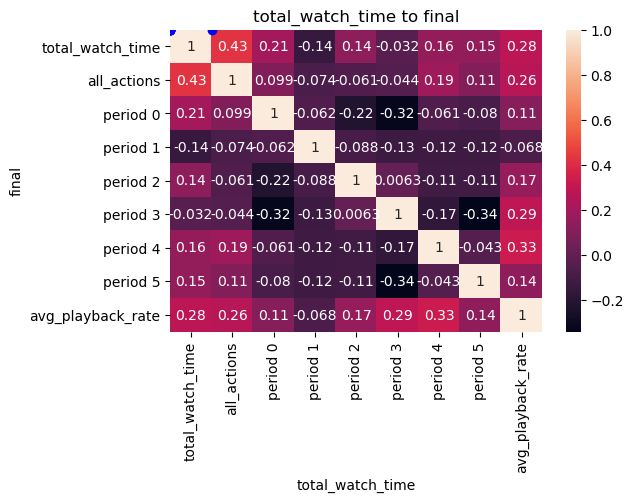

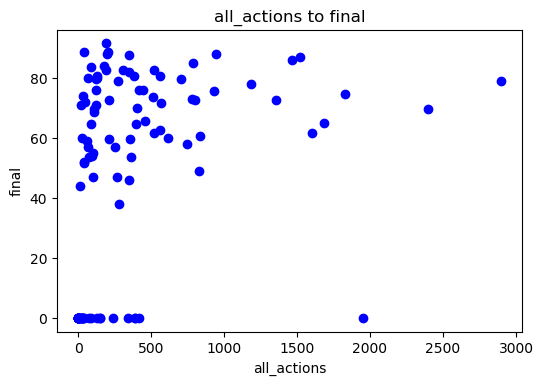

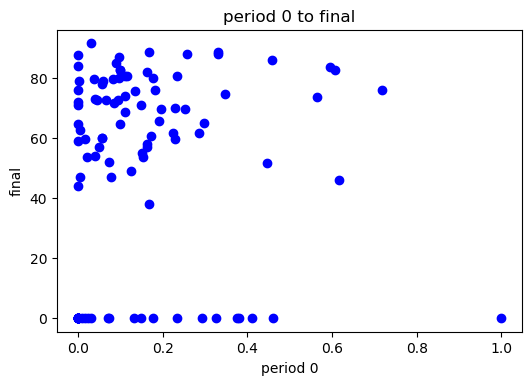

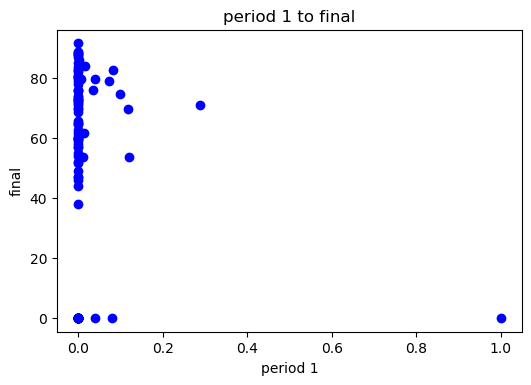

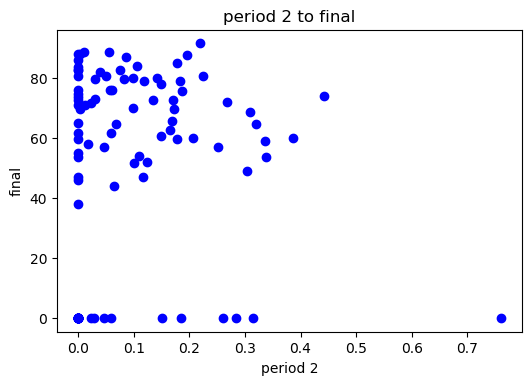

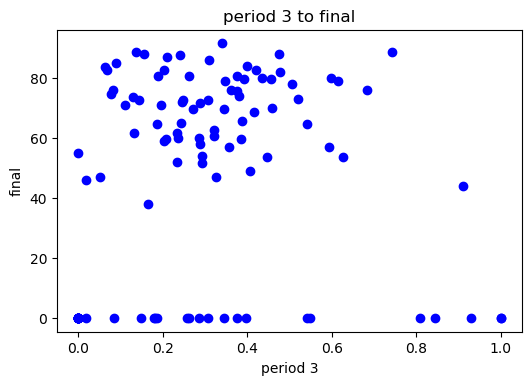

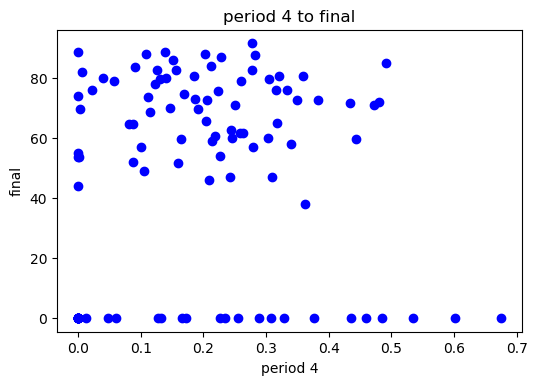

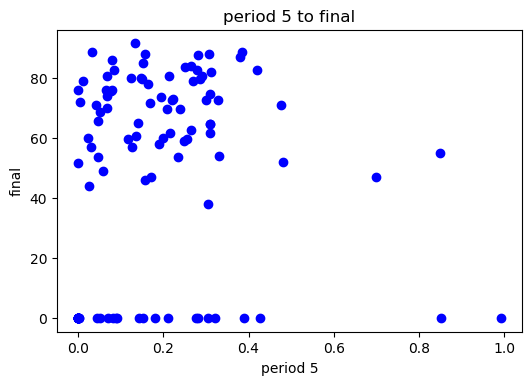

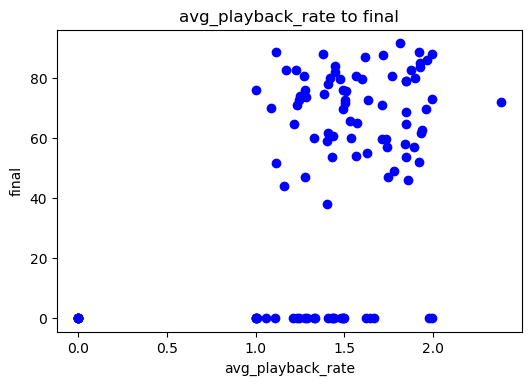

                            OLS Regression Results                            
Dep. Variable:             Q("final")   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     11.36
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           6.77e-12
Time:                        01:46:54   Log-Likelihood:                -481.28
No. Observations:                 105   AIC:                             982.6
Df Residuals:                      95   BIC:                             1009.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.61

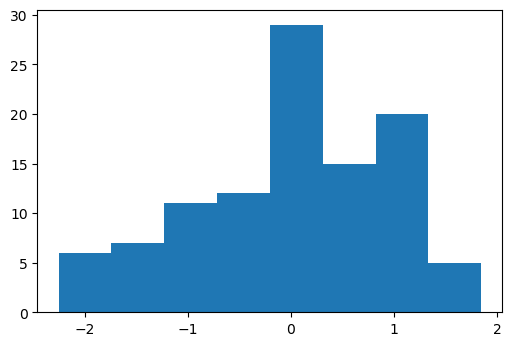

QQ plot


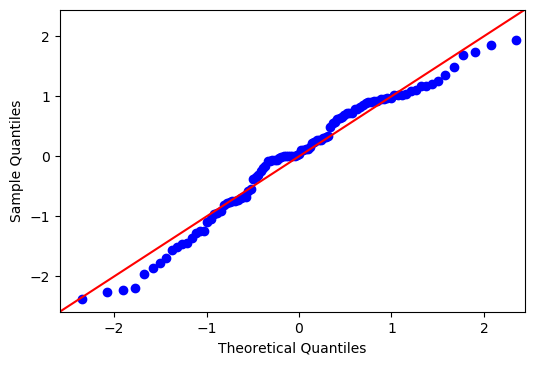

Influential Observations
[9.70875638e-03 1.33650117e-03 9.48398783e-03 1.39382448e-03
 4.32373545e-04 3.22508867e-02 1.65124021e-03 1.23495429e-02
 1.60156044e-03 3.88942569e-03 1.85551489e-05 5.70026316e-03
 6.32719235e-03 2.31628197e-03 1.13619626e-02 1.83648120e-02
 7.51529508e-05 1.24499334e-02 3.62245340e-04 2.05867442e-02
 1.68293155e-03 3.89064698e-04 8.50485737e-06 1.70443708e+00
 2.88831965e-03 1.26786926e-02 9.74307923e-03 1.96494935e-02
 3.59034038e-03 1.98044733e-03 1.59371929e-02 4.55141491e-04
 5.12384949e-04 2.12720614e-03 2.17411323e-02 1.10884059e-03
 2.40143521e-02 1.01395728e-32 6.04453631e-03 1.18417747e-02
 3.97770218e-02 3.65955521e-03 9.46369847e-03 4.16260441e-04
 7.16581487e-03 4.92496121e-05 4.11460933e-03 7.74831968e-05
 1.01395728e-32 7.96366670e-07 3.70392755e-02 1.52725666e-02
 1.75439470e-01 4.50137616e-06 3.50755626e-04 5.01452190e-05
 1.01395728e-32 9.01341590e-03 2.46395177e-02 5.30920029e-03
 5.26694946e-03 9.10011715e-03 2.75308967e-02 7.74160146e-03

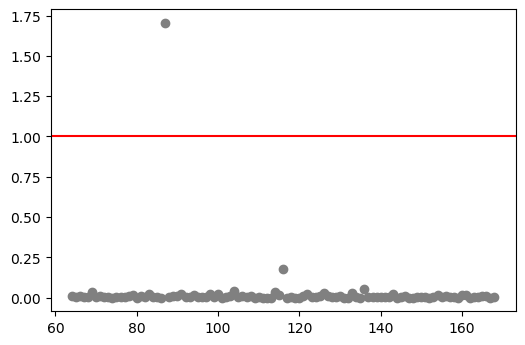

Outliers


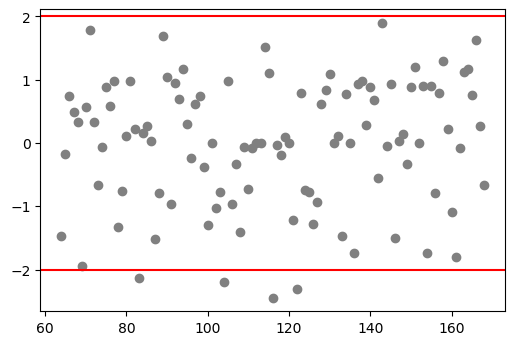

In [73]:
x_labels = cols
y_label = 'final'
st, data, ss2 = reg_analysis(DSAP107_sub, x_labels, y_label)

In [68]:
x_labels = cols
y_label = 'final'
forward_selection(DSAP107_sub, cols, y_label)

Current Candidates:  ['total_watch_time', 'all_actions', 'period 0', 'period 1', 'period 2', 'period 3', 'period 4', 'period 5', 'avg_playback_rate']


PatsyError: expected a noun, but instead the expression ended
    Q("final") ~ Q("total_watch_time")+
                                      ^

## Check the outliers

In [ ]:
outliers = pd.DataFrame(data[(abs(data[:,10]))>2])

In [ ]:
outliers

In [354]:
DSAP107_sub.loc[list(outliers[0])]

,student_id,Midterm (2042),Final (2346),total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
20.0,87,0,0.0,14.000000,0.002193,0,0,100,4,2,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000
35.0,108,13,0.0,14514.733333,0.540704,5051,64,5789,357,138,0.074242,0.0,0.185526,0.286509,0.132178,0.321545,1.277874
44.0,117,87,57.0,14376.400000,0.768865,702,47,1332,21,125,0.163764,0.0,0.251303,0.356077,0.101252,0.127605,1.893729
50.0,126,0,0.0,2638.500000,0.167370,27,1,0,0,12,0.461626,0.0,0.000000,0.000000,0.485882,0.052492,1.977639


## check influential observations

In [355]:
influ_obs = pd.DataFrame(data[ (abs(data[:,11]))>1])

In [356]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,0.0,11.506457,23.354519,-34.96171,57.974624,-56.200761,79.213675,-11.506457,8.192188,-1.404565,1.336116


In [357]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,0.0,11.506457,23.354519,-34.96171,57.974624,-56.200761,79.213675,-11.506457,8.192188,-1.404565,1.336116


In [358]:
DSAP107_sub.loc[list(influ_obs[0])]

,student_id,Midterm (2042),Final (2346),total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
21.0,91,0,0.0,3111.05,0.11756,686,40,753,90,41,0.148653,0.0,0.0,0.0,0.0,0.851347,1.332348


## Extract outliers and influential data

In [359]:
DSAP107_sub.loc[list(outliers[0])+list(influ_obs[0])]

,student_id,Midterm (2042),Final (2346),total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,avg_playback_rate
20.0,87,0,0.0,14.000000,0.002193,0,0,100,4,2,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000
35.0,108,13,0.0,14514.733333,0.540704,5051,64,5789,357,138,0.074242,0.0,0.185526,0.286509,0.132178,0.321545,1.277874
44.0,117,87,57.0,14376.400000,0.768865,702,47,1332,21,125,0.163764,0.0,0.251303,0.356077,0.101252,0.127605,1.893729
50.0,126,0,0.0,2638.500000,0.167370,27,1,0,0,12,0.461626,0.0,0.000000,0.000000,0.485882,0.052492,1.977639
21.0,91,0,0.0,3111.050000,0.117560,686,40,753,90,41,0.148653,0.0,0.000000,0.000000,0.000000,0.851347,1.332348


In [360]:
DSAP107_sub.loc[list(outliers[0])+list(influ_obs[0])]['student_id']

20.0     87
35.0    108
44.0    117
50.0    126
21.0     91
Name: student_id, dtype: int64

In [361]:
DSAP107_sub = DSAP107_sub[~DSAP107_sub.index.isin(list(outliers[0])+list(influ_obs[0]))]

In [362]:
DSAP107_sub.reset_index(drop=True, inplace=True)

In [363]:
len(DSAP107_sub)

88